In [14]:
import time

import matplotlib.pyplot as plt
import numpy as np
import sympy

from devito import Grid, Eq, Operator, TimeFunction, solve
from devito.logger import log

In [15]:
def before_shut_in(ui, spacing=0.01, a=0.5, timesteps=50, b=0.1, pres = 100):
    nx, ny = ui.shape
    dx2, dy2 = spacing**2, spacing**2
    dt = dx2 * dy2 / (2 * a * (dx2 + dy2))
    # Allocate the grid and set initial condition
    grid = Grid(shape=(nx, ny))
    u = TimeFunction(name='u', grid=grid, time_order=1, space_order=2)
    u.data[0, :] = ui[:]
    # Derive the stencil according to devito conventions
    eqn = Eq(u.dt, a * (u.dx2 + u.dy2) + b * (pres - u))
    stencil = solve(eqn, u.forward)
    
    # bc1: we are bumping water out of the well
    bc1 = [Eq(u[1, nx//2, ny//2], 0)]
    
    x, y = grid.dimensions
    # bc2: Neumann boundary condition
    # create boundary condition
    bc = [Eq(u[1, 0,    y],    u[1, 1,    y])]
    bc+= [Eq(u[1, nx-1, y],    u[1, nx - 2, y])]
    bc+= [Eq(u[1, x, ny-1],    u[1, x, ny - 2])]
    bc+= [Eq(u[1, x,    0],    u[1, x,    1])]
    
    # operator
    op = Operator([Eq(u.forward, stencil)] + bc1 + bc)

    # Execute the generated Devito stencil operator
    tstart = time.time()
    op.apply(u=u, t=timesteps, dt=dt)
    runtime = time.time() - tstart
    log("Devito: Diffusion with dx=%0.4f, dy=%0.4f, executed %d timesteps in %f seconds"
        % (spacing, spacing, timesteps, runtime))
    return u.data[1, :], runtime

In [16]:
def aft_shut_in(ui, spacing=0.01, a=0.5, timesteps=50, b=0.1, pres = 100):
    """
    :param ui: The initial condition of the grid as a 2D numpy array.
    :param spacing: The spacing length between grid points. Default value is 0.01.
    :param a: The diffusion coefficient. Default value is 0.5.
    :param timesteps: The number of timesteps to execute the diffusion. Default value is 50.
    :return: A tuple containing two elements: the final state of the grid after timesteps executions and the runtime in seconds.

    """
    nx, ny = ui.shape
    dx2, dy2 = spacing**2, spacing**2
    dt = dx2 * dy2 / (2 * a * (dx2 + dy2))
    # Allocate the grid and set initial condition
    grid = Grid(shape=(nx, ny))
    u = TimeFunction(name='u', grid=grid, time_order=1, space_order=2)
    u.data[0, :] = ui[:]
    # Derive the stencil according to devito conventions
    eqn = Eq(u.dt, a * (u.dx2 + u.dy2) + b * (pres - u))
    stencil = solve(eqn, u.forward)
    
    x, y = grid.dimensions
    # bc: Neumann boundary condition
    # create boundary condition
    bc = [Eq(u[1, 0,    y],    u[1, 1,    y])]
    bc+= [Eq(u[1, nx-1, y],    u[1, nx - 2, y])]
    bc+= [Eq(u[1, x, ny-1],    u[1, x, ny - 2])]
    bc+= [Eq(u[1, x,    0],    u[1, x,    1])]
    
    # operator
    op = Operator([Eq(u.forward, stencil)] + bc)

    # Execute the generated Devito stencil operator
    tstart = time.time()
    op.apply(u=u, t=timesteps, dt=dt)
    runtime = time.time() - tstart
    log("Devito: Diffusion with dx=%0.4f, dy=%0.4f, executed %d timesteps in %f seconds"
        % (spacing, spacing, timesteps, runtime))
    return u.data[1, :], runtime

In [17]:
# init grid 
nx, ny = 100, 100 # grid size
nt = 50 # time array before shut-in
nt2= 20 # time array after shut-in
tm = 0 # time for computation
pres = 100 # reservoir pressure
# grid pressure data
grid = np.ones((nx, ny)) * pres
grid[nx//2, ny//2] = 0

In [23]:
# iteration through different a(kappa1)
kapp1_array = np.linspace(1e-4, 1e-3, 20)
res_array = np.zeros((nx//2, len(kapp1_array))) # store the data before shut-in
res_array2= np.zeros((nx//2, len(kapp1_array))) # store the data after shut-in
i1 = 0
from tqdm.notebook import tqdm

for iter in tqdm(kapp1_array):
    # result storage
    data = np.zeros((nx, ny, nt))
    data2= np.zeros((nx, ny, nt2))
    data[:,:,0] = grid
    for i in range(1, nt):
        data[:,:,i], tm = before_shut_in(data[:,:,i-1], spacing=0.01, a=iter, timesteps=1, b=0.1, pres = 100)
    data2[:,:,0] = data[:,:,-1]
    for i in range(1, nt2):
        data2[:,:,i], tm = aft_shut_in(data2[:,:,i-1], spacing=0.01, a=iter, timesteps=1, b=0.1, pres = 100)
    res_array[:, i1] = data[nx//2:, ny//2, -1]
    res_array2[:,i1] = data2[nx//2:,ny//2, -1]
    i1 = i1 + 1

  0%|          | 0/20 [00:00<?, ?it/s]

Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.258306 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.013703 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.014477 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.016440 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.013894 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.017932 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.014114 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with dx=0.0100, dy=0.0100, executed 1 timesteps in 0.013724 seconds
Operator `Kernel` ran in 0.01 s
Devito: Diffusion with d

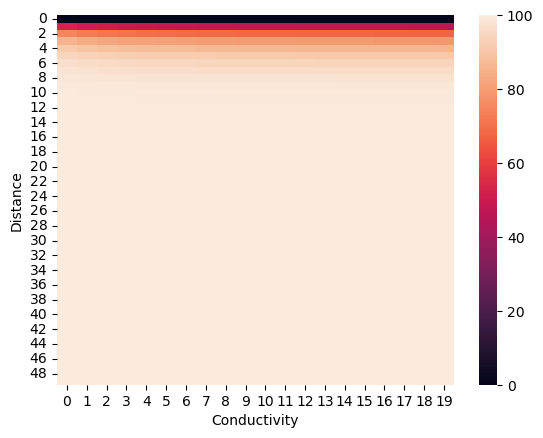

In [24]:
import seaborn as sns
plt.figure()
sns.heatmap(res_array)
plt.xlabel("Conductivity")
plt.ylabel("Distance")
plt.show()

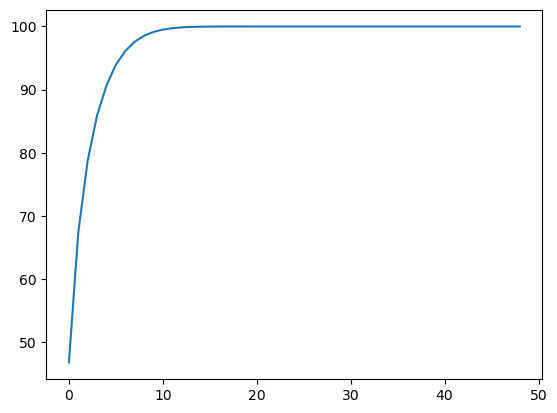

In [25]:
plt.figure()
plt.plot(data[nx//2+1:, ny//2, -1])
plt.show()